# Hyperlinks' clickability preferences

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.parse
import seaborn as sns

In [2]:
import os, sys

# HTLM files URLs in a list 
wp_path = "/Users/ginevralarroux/Desktop/EPFL courses/Applied data analysis/ADA project/data/wpcd/wp/" # to adapt
directories = os.listdir(wp_path)
html_list = []
for dir in directories:
    local_path = wp_path + dir
    local_dir = os.listdir(local_path)
    for link in local_dir:
        if link[-3:]=='htm':
            html_list.append(dir+'/'+link)
html_list[:10]

['r/Royal_Marines.htm',
 'r/Recycling.htm',
 'r/Retreat_of_glaciers_since_1850.htm',
 'r/Remember_Girls_Like_Rajpura.htm',
 'r/Rutherfordium.htm',
 'r/Rule_of_St_Benedict.htm',
 'r/Red_dwarf.htm',
 'r/Romeo_and_Juliet.htm',
 'r/Rudyard_Kipling.htm',
 'r/Race.htm']

## Objective

The aim of this specific section of our game strategy analysis is to test whether Wikispeedia players have clikability preferences on the basis of the hyperlinks' positioning throughout the article text. 
In particular:
1. we wil find the ordinal number of the paragraph each hyperlink in an article shows up in and divide it by the total number of paragraphs of the article, to determine its positioning; 
2. we will determine if each hyperlink in an article shows up in an image caption.

We will then investigate if there is a correlation between the clickability of the hyperlinks and their location, using the proper statistical tests. 

### Hyperlinks positioning in articles' text

It is essential to extract from the data the frequency of clicks for each hyperlink.

In [3]:
# read files 
folder='/Users/ginevralarroux/Desktop/EPFL courses/Applied data analysis/ADA project/data/wikispeedia_paths-and-graph/'

paths_finished='paths_finished.tsv'
paths_unfinished='paths_unfinished.tsv'
articles='articles.tsv'

paths_finished=pd.read_csv(folder+paths_finished, sep='\t', skiprows=15, header=None, names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating'])
paths_unfinished=pd.read_csv(folder+paths_unfinished, sep='\t', skiprows=16, header=None, names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'target', 'type'])
articles=pd.read_csv(folder+articles, sep='\t', skiprows=12, header=None, names=['article'])

The dataframe `paths_finished` contains the paths chosen by the players who could reach the target article.

In [4]:
paths_finished.head()

,hashedIpAddress,timestamp,durationInSec,path,rating
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0


The dataframe `paths_unfinished` contains the paths chosen by the players who could not reach the target article.

In [5]:
paths_unfinished.head()

,hashedIpAddress,timestamp,durationInSec,path,target,type
0,2426091a53125110,1297054935,1804,Obi-Wan_Kenobi,Microsoft,timeout
1,26141fd878806294,1297055651,1805,Julius_Caesar,Caracas,timeout
2,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout
3,53a53bc244e08a6a,1297094761,49,Paraguay,Mount_St._Helens,restart
4,53a53bc244e08a6a,1297099105,1808,Paraguay;Bolivia,Mount_St._Helens,timeout


The dataframe `articles` lists all the clickable articles/links.

In [6]:
# encode and filter link names
def filter_link(link):
    link=urllib.parse.unquote(link)
    link=link.lower()
    link=link.replace('_', ' ')
    link=link.strip()
    return link

articles.article=articles.article.apply(filter_link)
articles.head(10)

,article
0,áedán mac gabráin
1,åland
2,édouard manet
3,éire
4,óengus i of the picts
5,€2 commemorative coins
6,10th century
7,11th century
8,12th century
9,13th century


In [7]:
print('The total number of articles comprising the Wikispeedia library is {0}.'.format(len(articles)))

The total number of articles comprising the Wikispeedia library is 4604.


The dataframe `clicked_links_filtered` contains the clicked links troughout the paths.

In [8]:
def get_clicked_links(paths_df):
    clicked_links=[]
    removed_idxs=[]
    for idx, path in enumerate(paths_df['path']): 
        links_list=(path.split(';'))# get list of links along the path string 
        links_list_uncoded=[filter_link(link) for link in links_list]
        if (len(links_list_uncoded)) <= 1 or ('<' in links_list_uncoded):
            removed_idxs.append(idx)
            continue
        else:
            clicked_links.append(links_list_uncoded)
    return clicked_links, removed_idxs

clicked_links_filtered_f, removed_f=get_clicked_links(paths_finished) #f for paths_finished
clicked_links_filtered_u, removed_u=get_clicked_links(paths_unfinished) #u for paths_unfinished
clicked_links_filtered_f[:5]

[['14th century',
  '15th century',
  '16th century',
  'pacific ocean',
  'atlantic ocean',
  'accra',
  'africa',
  'atlantic slave trade',
  'african slave trade'],
 ['14th century',
  'europe',
  'africa',
  'atlantic slave trade',
  'african slave trade'],
 ['14th century',
  'niger',
  'nigeria',
  'british empire',
  'slavery',
  'africa',
  'atlantic slave trade',
  'african slave trade'],
 ['14th century', 'renaissance', 'ancient greece', 'greece'],
 ['14th century',
  'italy',
  'roman catholic church',
  'hiv',
  'ronald reagan',
  'president of the united states',
  'john f. kennedy']]

In [9]:
print('W.r.t the succesfull players dataframe, a total number of {0} paths are kept, out of {1}: {2} were discarded.'.format(len(clicked_links_filtered_f), len(removed_f)+len(clicked_links_filtered_f), len(removed_f))) 
##need to comment why do that

W.r.t the succesfull players dataframe, a total number of 42312 paths are kept, out of 51318: 9006 were discarded.


In [10]:
print('W.r.t the unsuccesfull players dataframe, a total number of {0} paths are kept, out of {1}: {2} were discarded.'.format(len(clicked_links_filtered_u),len(clicked_links_filtered_u)+len(removed_u),\
                                                                                                                               len(removed_u)))


W.r.t the unsuccesfull players dataframe, a total number of 14460 paths are kept, out of 24875: 10415 were discarded.


The dataframe `links_freq_df` contains the links' frequency of clicks.

In [11]:
def get_clicks_frequency(paths_list):
    
    links_name=[]
    links_freq=[]

    for article in articles['article']: # count the number of times each article shows up in paths
        count=0
        links_name.append(article)
        for path in range(len(paths_list)):
            if article in paths_list[path]:
                count+=paths_list[path].count(article)
        links_freq.append(count)

    links_freq_df=pd.concat([pd.Series(links_name), pd.Series(links_freq)], axis=1)
    links_freq_df.columns=['link', '#_clicks']
    return links_freq_df

links_freq_df_f=get_clicks_frequency(clicked_links_filtered_f)
links_freq_df_u=get_clicks_frequency(clicked_links_filtered_u)

links_freq_df_f.loc[links_freq_df_f['#_clicks']!=0].head()

,link,#_clicks
1,åland,1
2,édouard manet,1
3,éire,1
5,€2 commemorative coins,1
6,10th century,66


In [12]:
clicks_tot_f=links_freq_df_f['#_clicks'].sum()
clicks_tot_u=links_freq_df_u['#_clicks'].sum()
print('The total number of clicked hyperlinks by succesfull players is {0}.'.format(clicks_tot_f))
print('The total number of clicked hyperlinks by unsuccesfull players is {0}.'.format(clicks_tot_u))

The total number of clicked hyperlinks by succesfull players is 242257.
The total number of clicked hyperlinks by unsuccesfull players is 68711.


Next step of the descriptive analysis process is the html files parsing aimed at determining the location of hyperlinks. 

In [13]:
# parse html files 

from bs4 import BeautifulSoup

soups=[]
failed_html_list = []
for html in html_list[:]:
    f=open(wp_path+html, 'r')
    try:
        soup = BeautifulSoup(f, 'lxml')
        soups.append(soup)
    except Exception:
        failed_html_list.append(html)

In [14]:
print('{0} files were not parsable. However, they are not reachable nor it is possible to click \
any hyperlink in those html pages.'.format(len(failed_html_list)))

53 files were not parsable. However, they are not reachable nor it is possible to click any hyperlink in those html pages.


`link_positioning_dfs` is a list of dataframes (`link_positioning_df`) containing hyperlinks showing up in one html file, the ordinal number of the paragraph they belong to and their relative positioning throughout the article text. 

In [15]:
# HTML tag for hyperlinks is <a href= >
# the function finds all <a href= > tags throughout the article html file

def find_links(soup): 
    paragraphs = soup.find_all('p') 
    links=[]
    i=0
    for p in paragraphs:
        i+=1
        all_links=p.find_all('a')
        for link in all_links:
            if 'href' in link.attrs:
                link_title=link.text
                link_paragraph=i
                links.append([link_title, link_paragraph])
                
    link_positioning_df=pd.DataFrame(links, columns=['link', '#_paragraph']).drop_duplicates()
    link_positioning_df['positioning']=round(link_positioning_df['#_paragraph']/len(paragraphs), 2)
    link_positioning_df['link']=link_positioning_df['link'].apply(filter_link)
    return link_positioning_df

In [16]:
# apply the function to all html files

link_positioning_dfs=[]
for soup in soups:
    link_positioning_dfs.append(find_links(soup))

link_positioning_dfs[:5]

[                              link  #_paragraph  positioning
 0                       royal navy            1         0.01
 1                   united kingdom            1         0.01
 2                         cold war           18         0.19
 3                     sierra leone           20         0.21
 4                         dartmoor           24         0.25
 5                     world war ii           29         0.30
 6                         plymouth           34         0.35
 7                         scotland           34         0.35
 8                        gibraltar           43         0.44
 9                             cuba           44         0.45
 10               george washington           44         0.45
 11                      royal navy           45         0.46
 13                      portsmouth           46         0.47
 14                        plymouth           46         0.47
 15      american revolutionary war           46         0.47
 16     

In [17]:
print('{0} html files were parsed.'.format(len(link_positioning_dfs)))

5409 html files were parsed.


In [18]:
# example with 2 files

URL_1 = wp_path+'a/A_cappella.htm'
URL_2 = wp_path+'m/Music.htm'

f1=open(URL_1, 'r')
soup1 = BeautifulSoup(f1, 'lxml')

f2=open(URL_2, 'r')
soup2 = BeautifulSoup(f2, 'lxml')

link_positioning_df_1=find_links(soup1).drop(labels='#_paragraph', axis=1)
link_positioning_df_2=find_links(soup2).drop(labels='#_paragraph', axis=1)

# merging the 2 dataframes 

merged_dfs=link_positioning_df_1.merge(link_positioning_df_2, how='outer', left_on='link', right_on='link', )
merged_dfs

,link,positioning_x,positioning_y
0,music,0.04,NaN
1,instrumental,0.04,NaN
2,renaissance,0.04,NaN
3,renaissance,0.12,NaN
4,gregorian chant,0.12,NaN
5,amish,0.21,NaN
6,eastern orthodox,0.21,NaN
7,jewish,0.33,NaN
8,beatles,0.75,NaN
9,hindi,0.88,NaN


The hyperlink _rap_ shows up in both articles; the hyperlink _jazz_, _renaissance_ and _time_ show up multiple times in one article. 

The two occurrences highlighted are likely to be the case for every hyperlink, when all dataframes will be merged. It is therefore essential to compute their most likely positioning in the articles' texts, so to extract any meaningful information from the data.  

In [19]:
# merge all the link_positioning_df in link_positioning_dfs list on hyperlink in order to apply a function 
# that determines the most frequent positioning of the hyperlinks

link_positioning_dfs_grouped=[]

fail=0  
for i, df in enumerate(link_positioning_dfs):
    try:
        df=df.set_index("link")
        df=df["positioning"].groupby("link").apply(lambda x: x.values).rename(f"article_{i}")
        link_positioning_dfs_grouped.append(df)
    except:
        fail+=1
        pass 

from itertools import chain
link_positioning_concatenated=(pd.concat(link_positioning_dfs_grouped)
                               .groupby("link")
                               .apply(lambda x: list(chain(*x.values))))
link_positioning_concatenated[:10]

link
                                [0.78, 0.8, 0.84, 0.85, 0.87, 0.89, 0.91, 0.93...
"6 villages for 2006                                                       [0.67]
"6 villages for 2006"                                                [0.36, 0.46]
"capitalist rule"                                                          [0.16]
"consumption" (tuberculosis)                                               [0.03]
"glorious revolution"                                                      [0.39]
"grave"                                                                    [0.31]
"law of queen anne"                                                        [0.52]
"name and anagram"                                                          [0.1]
"nostalgic tram" no. 91                                                    [0.76]
dtype: object

In [20]:
# function that determines the most frequent positioning of each hyperlink in the set of all links

def find_positioning(array):
    bin_labels=['top', 'center-top','center','center-bottom', 'bottom'] # positioning is classified as top, centre-top, center, center-bottom, or bottom of the article
    bins=[0, 0.20, 0.40, 0.60, 0.80, 1] 
    cut_positioning=pd.cut(array, bins, labels=bin_labels, right=True, include_lowest=True)
    positioning_frequency=pd.value_counts(cut_positioning) # frequency of the bins
    most=positioning_frequency.apply('max') # bin with highest frequency
    if len(positioning_frequency[positioning_frequency==most])>1:
        return np.random.choice(positioning_frequency[positioning_frequency==most].index.values.astype(str)) #account for same frequency
    else:
        return positioning_frequency[positioning_frequency==most].index.values.astype(str).item()

The dataframe `most_freq_positioning_df` contains the hyperlinks' most frequent positioning.

In [21]:
# all html files

most_freq_positioning=link_positioning_concatenated.apply(find_positioning)
most_freq_positioning_df=pd.DataFrame(most_freq_positioning, columns=['most_freq_positioning'])
most_freq_positioning_df.reset_index(inplace=True)
most_freq_positioning_df.head()
most_freq_positioning_df.to_csv('most_freq_positioning_df.csv')

The dataframe `links_freq_pos` contains both the hyperlinks' most frequent positioning and their frequency of clicks.

In [22]:
links_freq_pos_f=links_freq_df_f.merge(most_freq_positioning_df, how='outer', left_on='link', right_on='link')
links_freq_pos_u=links_freq_df_u.merge(most_freq_positioning_df, how='outer', left_on='link', right_on='link')
links_freq_pos_f.head()

,link,#_clicks,most_freq_positioning
0,áedán mac gabráin,0.0,top
1,åland,1.0,bottom
2,édouard manet,1.0,center-bottom
3,éire,1.0,top
4,óengus i of the picts,0.0,NaN


In [23]:
print('In {0} out of {1} cases clicked links by players don\'t have a most frequent positioning as they do not show up \
in the dataframe containing hyperlinks in HTML pages. They are replaced with random values.'\
      .format((links_freq_pos_f['most_freq_positioning'].isna()).sum(), len(links_freq_pos_f)))

In 987 out of 11520 cases clicked links by players don't have a most frequent positioning as they do not show up in the dataframe containing hyperlinks in HTML pages. They are replaced with random values.


In [24]:
print('In {0} out of {1} cases clicked links by players don\'t have a most frequent positioning as they do not show up \
in the dataframe containing hyperlinks in HTML pages. They are replaced with random values.'\
      .format((links_freq_pos_u['most_freq_positioning'].isna()).sum(), len(links_freq_pos_u)))

In 987 out of 11520 cases clicked links by players don't have a most frequent positioning as they do not show up in the dataframe containing hyperlinks in HTML pages. They are replaced with random values.


In [25]:
links_freq_pos_f['most_freq_positioning'].\
fillna(np.random.choice(['top', 'center-top','center','center-bottom', 'bottom']),inplace=True)
links_freq_pos_u['most_freq_positioning'].\
fillna(np.random.choice(['top', 'center-top','center','center-bottom', 'bottom']),inplace=True)                                           

In [26]:
links_freq_pos_f.to_csv('links_freq_pos_f.csv')
links_freq_pos_u.to_csv('links_freq_pos_u.csv')

In [27]:
links_freq_pos_f['#_clicks'].fillna(0,inplace=True) #count NaN as 0 frequency
links_freq_pos_u['#_clicks'].fillna(0,inplace=True)
not_clicked_f=(links_freq_pos_f['#_clicks']==0).sum() #null #_clicks
not_clicked_u=(links_freq_pos_u['#_clicks']==0).sum()
print('There are {0} links in the articles, {1} never clicked by succesful players.'.format(len(most_freq_positioning_df), not_clicked_f))
print('There are {0} links in the articles, {1} never clicked by unsuccesful players.'.format(len(most_freq_positioning_df), not_clicked_u))

There are 10533 links in the articles, 7364 never clicked by succesful players.
There are 10533 links in the articles, 7617 never clicked by unsuccesful players.


In [28]:
print('In respectively {0}, {1} cases the number of clicks per link between successful and unsuccesful players is equal, not equal.'\
      .format((links_freq_pos_f['#_clicks']==links_freq_pos_u['#_clicks']).sum(), 
      (links_freq_pos_f['#_clicks']!=links_freq_pos_u['#_clicks']).sum()))

In respectively 7416, 4104 cases the number of clicks per link between successful and unsuccesful players is equal, not equal.


In [29]:
# problem!!!

The dataframe `links_freq_pos_grouped_df` groups the hyperlinks click frequency by their positioning.

In [30]:
links_freq_pos_grouped_f=pd.DataFrame(links_freq_pos_f['#_clicks'].groupby(links_freq_pos_f['most_freq_positioning']).sum())
links_freq_pos_grouped_f['#_clicks_norm']=links_freq_pos_grouped_f['#_clicks']/clicks_tot_f #normalization

links_freq_pos_grouped_u=pd.DataFrame(links_freq_pos_u['#_clicks'].groupby(links_freq_pos_u['most_freq_positioning']).sum())
links_freq_pos_grouped_u['#_clicks_norm']=links_freq_pos_grouped_u['#_clicks']/clicks_tot_u #normalization

links_freq_pos_grouped_f

,#_clicks,#_clicks_norm
most_freq_positioning,,
bottom,24085.0,0.099419
center,20014.0,0.082615
center-bottom,15623.0,0.064489
center-top,18631.0,0.076906
top,163904.0,0.676571


In [31]:
links_freq_pos_grouped_u

,#_clicks,#_clicks_norm
most_freq_positioning,,
bottom,6529.0,0.095021
center,3768.0,0.054838
center-bottom,6516.0,0.094832
center-top,4941.0,0.071910
top,46957.0,0.683399


In order to compare the hyperlinks click frequencies with regard to their positioning (i.e. _top_, _center-top_, _center_, _center-bottom_, _bottom_) their absolute values need to be normalized with the bins' frequencies (i.e. the number of times the hypelinks actually show up in the categorical positioning).

The dataframe `positioning_freq_df_grouped` contains the frequency of hyperlinks showing up in the Wikispeedia set of articles grouped by their positioning throughout the text. 

In [32]:
# function that counts the frequency of a link showing up at the top, center, bottom of the article

def find_positioning_dis(array):
    bin_labels=['top', 'center-top','center', 'center-bottom', 'bottom']
    bins=[0, 0.2, 0.4, 0.6, 0.8, 1]
    cut_positioning=pd.cut(array, bins, labels=bin_labels, right=True, include_lowest=True)
    positioning_frequency=pd.value_counts(cut_positioning)
    return positioning_frequency

In [33]:
# apply the function to the dataframe links positioning grouped by link  

positioning_freq=link_positioning_concatenated.apply(find_positioning_dis)
positioning_freq

,bottom,top,center-bottom,center,center-top
link,,,,,
,220,130,45,42,33
"""6 villages for 2006",0,0,1,0,0
"""6 villages for 2006""",0,0,0,1,1
"""capitalist rule""",0,1,0,0,0
"""consumption"" (tuberculosis)",0,1,0,0,0
...,...,...,...,...,...
‘6 villages for 2006’,0,0,1,0,1
“6 villages for 2006”,0,0,0,1,0
€,2,2,6,3,4


In [34]:
positioning_freq_grouped=pd.DataFrame(positioning_freq.sum(axis=0), columns=['nr']) # group by positioning

links_tot=positioning_freq_grouped['nr'].sum()
positioning_freq_grouped['nr_norm']=positioning_freq_grouped['nr']/links_tot
positioning_freq_grouped

,nr,nr_norm
bottom,24193,0.184871
top,40824,0.311957
center-bottom,22588,0.172607
center,20228,0.154573
center-top,23031,0.175992


In [35]:
# dataframe for visualization

vis_f=links_freq_pos_grouped_f.merge(positioning_freq_grouped, left_index=True, right_index=True)
vis_u=links_freq_pos_grouped_u.merge(positioning_freq_grouped, left_index=True, right_index=True)
vis_f

,#_clicks,#_clicks_norm,nr,nr_norm
bottom,24085.0,0.099419,24193,0.184871
center,20014.0,0.082615,20228,0.154573
center-bottom,15623.0,0.064489,22588,0.172607
center-top,18631.0,0.076906,23031,0.175992
top,163904.0,0.676571,40824,0.311957


In [36]:
vis_u

,#_clicks,#_clicks_norm,nr,nr_norm
bottom,6529.0,0.095021,24193,0.184871
center,3768.0,0.054838,20228,0.154573
center-bottom,6516.0,0.094832,22588,0.172607
center-top,4941.0,0.071910,23031,0.175992
top,46957.0,0.683399,40824,0.311957


In [37]:
vis_f['#_clicks / #_hyperlinks']=vis_f['#_clicks_norm']/vis_f['nr_norm']
vis_u['#_clicks / #_hyperlinks']=vis_u['#_clicks_norm']/vis_u['nr_norm']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


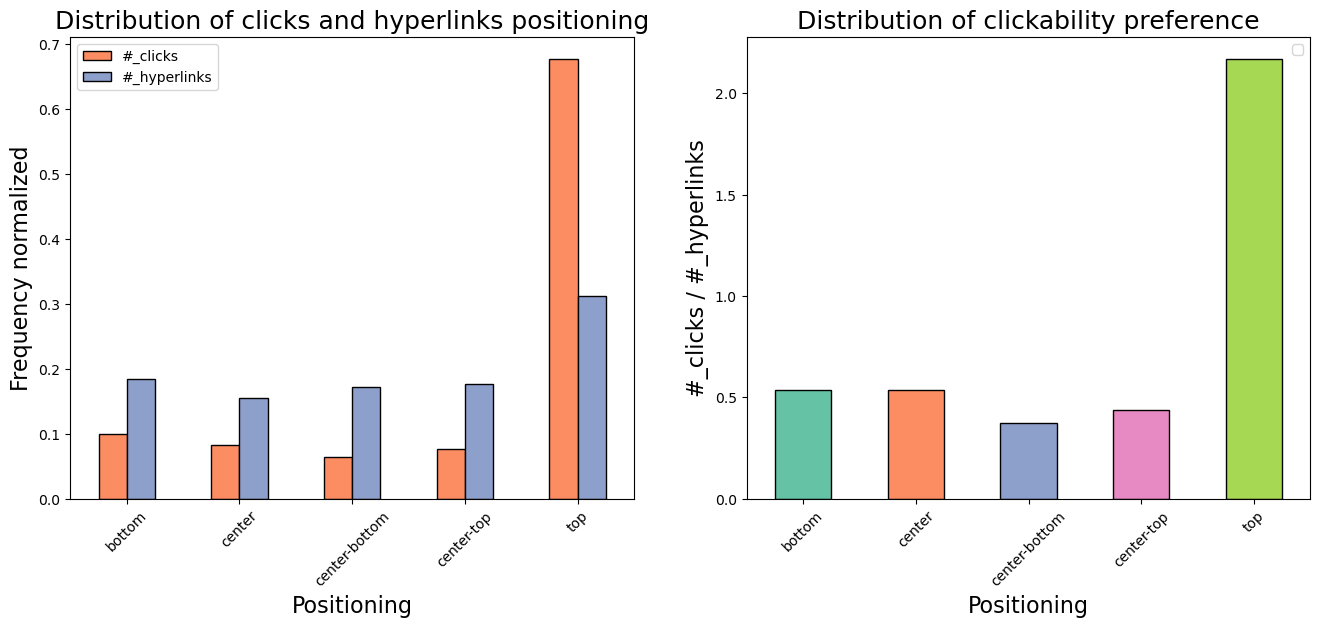

In [38]:
# visualization of the distribution of the clicked hyperlinks' positioning

fig, ax = plt.subplots(1,2, figsize=(16,6))

colors=sns.color_palette("Set2")


vis_f.plot(y=['#_clicks_norm', 'nr_norm'], kind='bar', ax=ax[0], label=['#_clicks', '#_hyperlinks'], color=colors[1:3], edgecolor='k')
ax[0].legend()
ax[0].set_title('Distribution of clicks and hyperlinks positioning', fontsize=18)
ax[0].set_xlabel('Positioning', fontsize=16)
ax[0].set_ylabel('Frequency normalized', fontsize=16)
ax[0].set_xticklabels(vis_f.index, rotation=45)

vis_f.plot(y='#_clicks / #_hyperlinks', kind='bar', ax=ax[1], label='', color=colors, edgecolor='k')
ax[1].legend()
ax[1].set_title('Distribution of clickability preference', fontsize=18)
ax[1].set_xlabel('Positioning', fontsize=16)
ax[1].set_ylabel('#_clicks / #_hyperlinks', fontsize=16)
ax[1].set_xticklabels(vis_f.index, rotation=45)

fig.savefig('fig_f.png', bbox_inches='tight')

In [39]:
colors=sns.color_palette("Set2")
colors

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


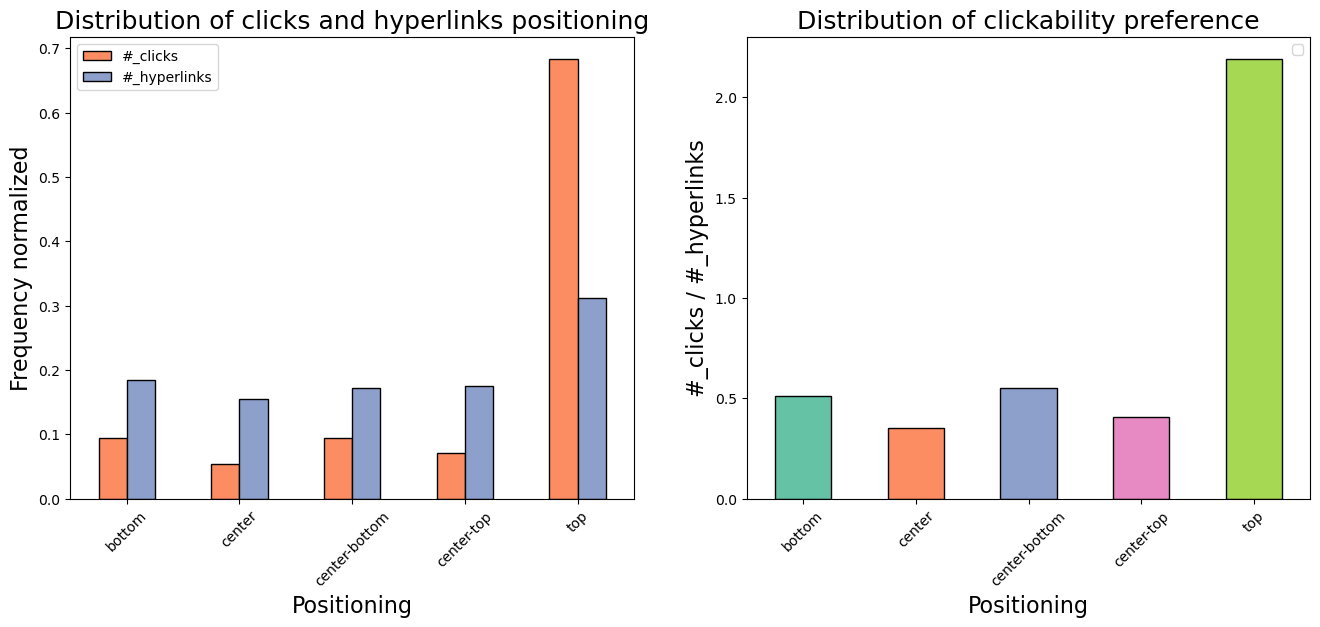

In [40]:
fig, ax = plt.subplots(1,2, figsize=(16,6))

colors=sns.color_palette("Set2")

vis_u.plot(y=['#_clicks_norm', 'nr_norm'], kind='bar', ax=ax[0], label=['#_clicks', '#_hyperlinks'], color=colors[1:3], edgecolor='k')
ax[0].legend()
ax[0].set_title('Distribution of clicks and hyperlinks positioning', fontsize=18)
ax[0].set_xlabel('Positioning', fontsize=16)
ax[0].set_ylabel('Frequency normalized', fontsize=16)
ax[0].set_xticklabels(vis_u.index, rotation=45)

vis_u.plot(y='#_clicks / #_hyperlinks', kind='bar', ax=ax[1], label='', color=colors, edgecolor='k')
ax[1].legend()
ax[1].set_title('Distribution of clickability preference', fontsize=18)
ax[1].set_xlabel('Positioning', fontsize=16)
ax[1].set_ylabel('#_clicks / #_hyperlinks', fontsize=16)
ax[1].set_xticklabels(vis_u.index, rotation=45)

fig.savefig('fig_u.png', bbox_inches='tight')

The bar plot on the left illustrates the distribution of the clicked hyperlinks and the total number of links in the articles, on the basis of their positioning throughout the articles text, both normalized. 

The bar plot on the right illustrates the hyperlinks clickability on the basis of their positioning. More precisely: 
1. a value of 1 (_\#_clicks_/_\#_hyperlinks_ = 1) corresponds to a hyperlinks clickability on average equally proportional to the normalized frequency of the specific categorical positioning (i.e. the number of clicks proportional to the number times a hyperlink shows up in a section of the article);
2. a value of greater than 1, points a more than proportional clickability;
3. a value of smaller than 1, points a less than proportional clickability.

In [41]:
vis_f['is_successful']=1
vis_u['is_successful']=0
vis=pd.concat([vis_f,vis_u], axis=0)
vis

,#_clicks,#_clicks_norm,nr,nr_norm,#_clicks / #_hyperlinks,is_successful
bottom,24085.0,0.099419,24193,0.184871,0.537775,1
center,20014.0,0.082615,20228,0.154573,0.534472,1
center-bottom,15623.0,0.064489,22588,0.172607,0.373620,1
center-top,18631.0,0.076906,23031,0.175992,0.436986,1
top,163904.0,0.676571,40824,0.311957,2.168792,1
bottom,6529.0,0.095021,24193,0.184871,0.513985,0
center,3768.0,0.054838,20228,0.154573,0.354774,0
center-bottom,6516.0,0.094832,22588,0.172607,0.549411,0
center-top,4941.0,0.071910,23031,0.175992,0.408598,0
top,46957.0,0.683399,40824,0.311957,2.190679,0


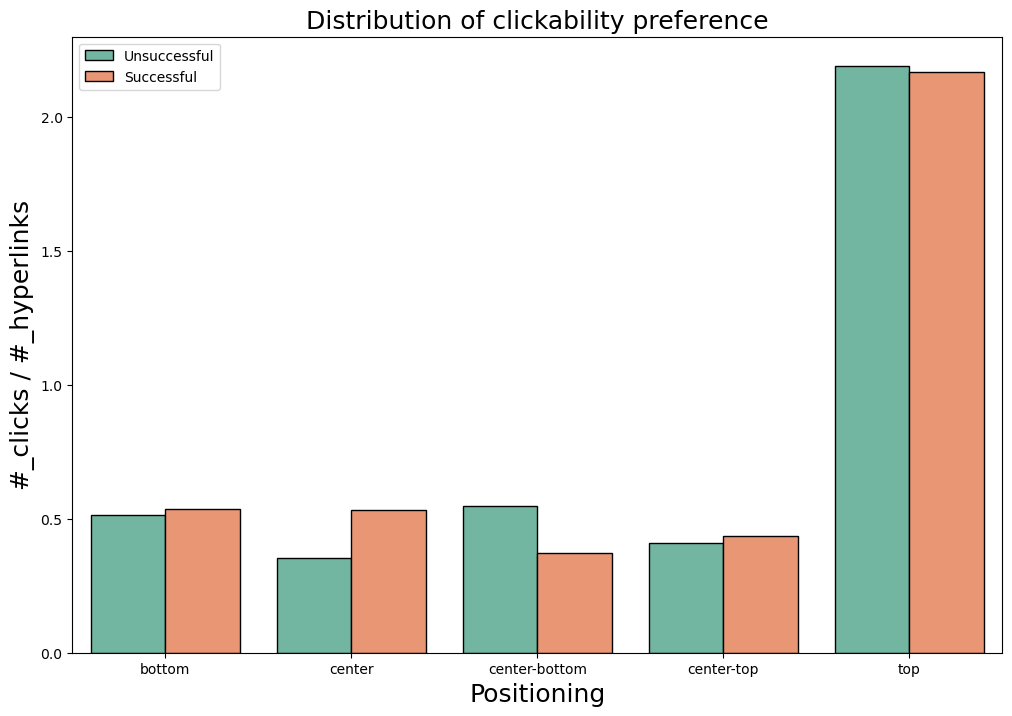

In [42]:
fig, ax = plt.subplots(figsize=(12,8), sharey=True)

sns.barplot(y='#_clicks / #_hyperlinks', x=vis.index, data=vis, palette=sns.color_palette("Set2"), hue='is_successful', edgecolor='k')

ax.set_title('Distribution of clickability preference', fontsize=18)
ax.set_xlabel('Positioning', fontsize=18)
ax.set_ylabel('#_clicks / #_hyperlinks', fontsize=18)
ax.legend_.set_title('')
labels = ['Unsuccessful', 'Successful']
for t, l in zip(ax.legend_.texts, labels):
    t.set_text(l)
plt.savefig('Distribution_clickability_preference_pos.png', bbox_inches='tight')

There is an evident players' clickability preference for hyperlinks showing up at the top of articles, followed by a preference for bottom and center-bottom positionings. <br>
The highest gap between successful and unsuccessful players is for hyperlinks in the center-bottom of articles: successful players click on average more on center-bottom-positioned links than unsuccesful ones. The trend is reversed for top-positioned links. 
Center-positioned links are clicked the least, both by successful and unsuccessful players. 

In [43]:
vis_f

,#_clicks,#_clicks_norm,nr,nr_norm,#_clicks / #_hyperlinks,is_successful
bottom,24085.0,0.099419,24193,0.184871,0.537775,1
center,20014.0,0.082615,20228,0.154573,0.534472,1
center-bottom,15623.0,0.064489,22588,0.172607,0.373620,1
center-top,18631.0,0.076906,23031,0.175992,0.436986,1
top,163904.0,0.676571,40824,0.311957,2.168792,1


In [44]:
vis_u

,#_clicks,#_clicks_norm,nr,nr_norm,#_clicks / #_hyperlinks,is_successful
bottom,6529.0,0.095021,24193,0.184871,0.513985,0
center,3768.0,0.054838,20228,0.154573,0.354774,0
center-bottom,6516.0,0.094832,22588,0.172607,0.549411,0
center-top,4941.0,0.071910,23031,0.175992,0.408598,0
top,46957.0,0.683399,40824,0.311957,2.190679,0


In [45]:
vis_f.to_csv('vis_f.csv')
vis_u.to_csv('vis_u.csv')

### Hyperlinks positioning in images' caption

The following part of the descriptive analysis focuses on the location of hyperlinks in images' captions.

Images in html files can be either found under \<div> or \<table> tag, while the hyperlinks are found in their captions under \<div class='thumbcaption'> tag.

The dataframe `links_in_tables` contains the links showing up in tables' captions. 

In [46]:
# parse html file and search hyperlinks in the captions of tables containing images 

def find_link_in_table(soup):
    
    tables = soup.find_all('table')

    links=[]
    for table in tables:
        if table.find('img'):
            all_links=table.find_all('a')
            for link in all_links:
                if 'class' not in link.attrs:
                    link_title=link.text
                    links.append(link_title)

    if links:
        links_in_table_df=pd.DataFrame(links).drop_duplicates()
        links_in_table_df.columns=['link']
        links_in_table_df['link']=links_in_table_df['link'].apply(filter_link) 
    else: 
        return None
    return links_in_table_df

In [47]:
links_in_tables=[]
for soup in soups:
    links_in_tables.append(find_link_in_table(soup))

links_in_tables_df=pd.concat(links_in_tables, axis=0)
links_in_tables_df.head()

,link
0,royal navy
1,united kingdom
3,plymouth
4,latin
0,lawrencium


In [48]:
links_in_tables_tot=len(links_in_tables_df)
print('The total number of links in tables captions is {0}.'.format(links_in_tables_tot))

The total number of links in tables captions is 15159.


The dataframe `links_in_images` contains the links showing up in images' captions.

In [49]:
# parse html file and search hyperlinks in the captions of div containing images 

def find_links_in_img(soup):
    div = soup.find_all('div')

    links=[]

    for d in div:
        if (d.find('a', class_="internal")):
            if (d.find('img', class_='thumbimage')):
                caption=d.find('div', class_="thumbcaption")
                if (caption.find('a')):
                    all_links=caption.find_all('a')
                    for link in all_links:
                        if 'class' not in link.attrs:
                            link_title=link.text
                            links.append(link_title)
    if links:
        links_in_image_df=pd.DataFrame(links).drop_duplicates()
        links_in_image_df.columns=['link']
        links_in_image_df['link']=links_in_image_df['link'].apply(filter_link) 
    else: 
        return None
        links_in_image_df=pd.DataFrame()
    return links_in_image_df

In [50]:
links_in_images=[]
for soup in soups:
    links_in_images.append(find_links_in_img(soup))


links_in_images_df=pd.concat(links_in_images, axis=0)
links_in_images_unique=pd.Series(links_in_images_df['link'].unique(), name='link')
links_in_images_unique.to_csv('links_in_images_unique.csv')

In [51]:
links_in_images_df[:5]

,link
0,bangladesh
0,portsmouth
2,england
4,india
0,pompeii


In [52]:
links_in_images_tot=len(links_in_images_df)
print('The total number of links in images captions is {0}.'.format(links_in_images_tot))

The total number of links in images captions is 372.


Next, the supposed clickability preference for a hyperlink showing up in an image will be investigated, by grouping the click frequency by hyperlinks' location.

In [53]:
# drop indexes to ease the flagging
links_in_images_df=links_in_images_df.reset_index(drop=True)
links_in_tables_df=links_in_tables_df.reset_index(drop=True)

The dataframe `links_freq_img` contains hyperlinks click frequency and a flag specifying if they can be found in images' captions.

In [54]:
# link in image

links_freq_img_f=links_freq_df_f.copy()
links_freq_img_u=links_freq_df_u.copy()

links_freq_img_f['in_image']=[1 if link in list(links_in_images_df['link']) else 0
                           for link in links_freq_img_f['link']]
links_freq_img_u['in_image']=[1 if link in list(links_in_images_df['link']) else 0
                           for link in links_freq_img_u['link']]

In [55]:
links_freq_img_f

,link,#_clicks,in_image
0,áedán mac gabráin,0,0
1,åland,1,1
2,édouard manet,1,1
3,éire,1,0
4,óengus i of the picts,0,0
...,...,...,...
4599,zionism,16,0
4600,zirconium,25,0
4601,zoroaster,12,0
4602,zuid-gelders,4,0


The dataframe `links_freq_tab` contains hyperlinks click frequency and a flag specifying if they can be found in tables' captions.

In [56]:
# link in table

links_freq_tab_f=links_freq_df_f.copy()
links_freq_tab_u=links_freq_df_u.copy()

links_freq_tab_f['in_tab']=[1 if link in list(links_in_tables_df['link']) else 0
                           for link in links_freq_tab_f['link']]
links_freq_tab_u['in_tab']=[1 if link in list(links_in_tables_df['link']) else 0
                               for link in links_freq_tab_u['link']]

### From now on the tabs and images will be joint

In [57]:
links_freq_concatenated_f=pd.concat([links_freq_img_f, links_freq_tab_f], axis=1)
links_freq_concatenated_u=pd.concat([links_freq_img_u, links_freq_tab_u], axis=1)
links_freq_concatenated_f

,link,#_clicks,in_image,link,#_clicks,in_tab
0,áedán mac gabráin,0,0,áedán mac gabráin,0,0
1,åland,1,1,åland,1,1
2,édouard manet,1,1,édouard manet,1,1
3,éire,1,0,éire,1,0
4,óengus i of the picts,0,0,óengus i of the picts,0,0
...,...,...,...,...,...,...
4599,zionism,16,0,zionism,16,1
4600,zirconium,25,0,zirconium,25,1
4601,zoroaster,12,0,zoroaster,12,0
4602,zuid-gelders,4,0,zuid-gelders,4,1


In [58]:
clicks_f=pd.Series(links_freq_concatenated_f['#_clicks'].sum(axis=1))
img_or_tab_f=pd.Series([links_freq_concatenated_f['in_image'][i] or links_freq_concatenated_f['in_tab'][i] \
                      for i,row in enumerate(links_freq_concatenated_f['in_image'])])
links_f=links_freq_img_f['link']

In [59]:
clicks_u=pd.Series(links_freq_concatenated_u['#_clicks'].sum(axis=1))
img_or_tab_u=pd.Series([links_freq_concatenated_u['in_image'][i] or links_freq_concatenated_u['in_tab'][i] \
                      for i,row in enumerate(links_freq_concatenated_u['in_image'])])
links_u=links_freq_img_f['link']

In [60]:
links_freq_img_and_tab_f=pd.DataFrame({'link': links_f, '#_clicks': clicks_f, 'in_image': img_or_tab_f})
links_freq_img_and_tab_u=pd.DataFrame({'link': links_u, '#_clicks': clicks_u, 'in_image': img_or_tab_u})
links_freq_img_and_tab_f

,link,#_clicks,in_image
0,áedán mac gabráin,0,0
1,åland,2,1
2,édouard manet,2,1
3,éire,2,0
4,óengus i of the picts,0,0
...,...,...,...
4599,zionism,32,1
4600,zirconium,50,1
4601,zoroaster,24,0
4602,zuid-gelders,8,1


In [ ]:
# find normalized values of clicks (#_clicks) on the basis of the relative number of times a hyperlink shows up in an 
# image caption to occurrence in the article text 

# images 

links_in_img=pd.concat(links_in_images, axis=0).reset_index(drop=True)

link_in_img_freq_df=pd.DataFrame(links_in_img['link'].value_counts()).reset_index()
link_in_img_freq_df.columns=['link', '#_link_in_img']
link_in_img_freq_df.to_csv('link_in_img_freq_df.csv')
link_in_img_freq_df

In [61]:
#images and tables

links_in_img_tab=pd.concat([links_in_images_df, links_in_tables_df], axis=0).reset_index(drop=True)

link_in_img_tab_freq_df=pd.DataFrame(links_in_img_tab['link'].value_counts()).reset_index()
link_in_img_tab_freq_df.columns=['link', '#_link_in_img']
link_in_img_tab_freq_df.to_csv('link_in_img_freq_df.csv')
link_in_img_tab_freq_df

,link,#_link_in_img
0,scientific classification,508
1,,424
2,animalia,398
3,time zone,340
4,chordata,330
...,...,...
2571,søren kierkegaard,1
2572,friedrich nietzsche,1
2573,"physicist,",1
2574,empire,1


In [62]:
links_in_img_tab_unique=pd.Series(links_in_img_tab['link'].unique(), name='link')
links_in_img_tab_unique.to_csv('links_in_img_tab_unique.csv')

In [63]:
# links showing up in articles

link_in_article=pd.concat(link_positioning_dfs, axis=0)['link']

link_in_article_freq_df=pd.DataFrame(link_in_article.reset_index(drop=True).value_counts()).reset_index()
link_in_article_freq_df.columns=['link', '#_link_in_article']
link_in_article_freq_df

,link,#_link_in_article
0,united states,1492
1,france,863
2,world war ii,862
3,europe,780
4,united kingdom,719
...,...,...
10530,carolingians,1
10531,convent,1
10532,monastic,1
10533,banaras,1


In [64]:
#images and tables
df_img_f=pd.merge(links_freq_img_and_tab_f, link_in_img_tab_freq_df, how='left', left_on='link', right_on='link')
df_img_u=pd.merge(links_freq_img_and_tab_u, link_in_img_tab_freq_df, how='left', left_on='link', right_on='link')

In [ ]:
df_img_f

In [ ]:
#just images
df_img_f=pd.merge(links_freq_img_f, link_in_img_freq_df, how='left', left_on='link', right_on='link')


In [65]:
new_df_img_f=pd.merge(df_img_f, link_in_article_freq_df, how='left', left_on='link', right_on='link')

new_df_img_f['#_clicks'].fillna(0, inplace=True) #consider Nan frequency as 0
new_df_img_f['#_link_in_article'].fillna(0, inplace=True) 
new_df_img_f['#_link_in_img'].fillna(0, inplace=True) 
new_df_img_f

,link,#_clicks,in_image,#_link_in_img,#_link_in_article
0,áedán mac gabráin,0,0,0.0,2.0
1,åland,2,1,2.0,4.0
2,édouard manet,2,1,3.0,10.0
3,éire,2,0,0.0,3.0
4,óengus i of the picts,0,0,0.0,0.0
...,...,...,...,...,...
4599,zionism,32,1,2.0,21.0
4600,zirconium,50,1,2.0,11.0
4601,zoroaster,24,0,0.0,5.0
4602,zuid-gelders,8,1,4.0,3.0


In [ ]:
#just images
df_img_u=pd.merge(links_freq_img_u, link_in_img_freq_df, how='left', left_on='link', right_on='link')

In [66]:
new_df_img_u=pd.merge(df_img_u, link_in_article_freq_df, how='left', left_on='link', right_on='link')

new_df_img_u['#_clicks'].fillna(0, inplace=True)
new_df_img_u['#_link_in_article'].fillna(0, inplace=True)
new_df_img_u['#_link_in_img'].fillna(0, inplace=True) 

In [67]:
links_freq_img_and_tab_u

,link,#_clicks,in_image
0,áedán mac gabráin,0,0
1,åland,2,1
2,édouard manet,2,1
3,éire,8,0
4,óengus i of the picts,0,0
...,...,...,...
4599,zionism,12,1
4600,zirconium,8,1
4601,zoroaster,2,0
4602,zuid-gelders,0,1


In [68]:
norm_values_img_f=new_df_img_f.loc[new_df_img_f['in_image']==1,'#_link_in_img']/new_df_img_f.loc[new_df_img_f['in_image']==1,'#_link_in_article'] #link in text counts also the clicks in images captions

links_freq_img_f_norm=links_freq_img_and_tab_f.copy()
links_freq_img_f_norm.loc[norm_values_img_f.index, '#_clicks']=(links_freq_img_f_norm.loc[norm_values_img_f.index,'#_clicks']*norm_values_img_f)
links_freq_img_f_norm.rename(columns={'#_clicks':'#_clicks_norm'}, inplace=True)
links_freq_img_f_norm['#_clicks_norm']=links_freq_img_f_norm['#_clicks_norm'].round(2)
links_freq_img_f_norm['#_clicks_norm'].replace(to_replace=np.inf, value=0, inplace=True)
links_freq_img_f_norm[:10]

,link,#_clicks_norm,in_image
0,áedán mac gabráin,0.00,0
1,åland,1.00,1
2,édouard manet,0.60,1
3,éire,2.00,0
4,óengus i of the picts,0.00,0
5,€2 commemorative coins,2.00,0
6,10th century,132.00,0
7,11th century,5.66,1
8,12th century,190.00,0
9,13th century,5.56,1


In [69]:
norm_values_img_u=new_df_img_u.loc[new_df_img_u['in_image']==1,'#_link_in_img']/new_df_img_u.loc[new_df_img_u['in_image']==1,'#_link_in_article'] #link in text counts also the clicks in images captions

links_freq_img_u_norm=links_freq_img_and_tab_u.copy()
links_freq_img_u_norm.loc[norm_values_img_u.index, '#_clicks']=(links_freq_img_u_norm.loc[norm_values_img_u.index,'#_clicks']*norm_values_img_u)
links_freq_img_u_norm.rename(columns={'#_clicks':'#_clicks_norm'}, inplace=True)
links_freq_img_u_norm['#_clicks_norm']=links_freq_img_u_norm['#_clicks_norm'].round(2)
links_freq_img_u_norm['#_clicks_norm'].replace(to_replace=np.inf, value=0, inplace=True)

links_freq_img_u_norm[:10]

,link,#_clicks_norm,in_image
0,áedán mac gabráin,0.00,0
1,åland,1.00,1
2,édouard manet,0.60,1
3,éire,8.00,0
4,óengus i of the picts,0.00,0
5,€2 commemorative coins,0.00,0
6,10th century,44.00,0
7,11th century,0.69,1
8,12th century,34.00,0
9,13th century,1.63,1


In [70]:
links_freq_img_f_norm.to_csv('links_freq_img_f_norm.csv')
links_freq_img_u_norm.to_csv('links_freq_img_u_norm.csv')

In [71]:
# tables 

#links_in_tab=pd.concat(links_in_tables, axis=0).reset_index(drop=True)
#
#link_in_tab_freq=[]
#link_name=[]
#
#for link in list(links_in_tab['link']):
#    count=list(links_in_tab['link']).count(link)
#    link_name.append(link)
#    link_in_tab_freq.append(count)
#
#link_name=pd.Series(link_name)
#link_in_tab_freq=pd.Series(link_in_tab_freq)
#link_in_tab_freq_df=pd.concat([link_name, link_in_tab_freq], axis=1)
#link_in_tab_freq_df.columns=['link', '#_link_in_tab']

In [72]:
#links_in_text=pd.concat(link_positioning_dfs, axis=0)['link']
#link_in_text_freq=[]
#link_name=[]
#
#for link in list(links_in_tab['link']):
#    count=list(links_in_text).count(link)
#    link_name.append(link)
#    link_in_text_freq.append(count)
#
#link_name_text=pd.Series(link_name)
#link_in_text_freq=pd.Series(link_in_text_freq)
#link_in_text_freq_df=pd.concat([link_name_text, link_in_text_freq], axis=1)
#link_in_text_freq_df.columns=['link', '#_link_in_text']

In [73]:
#df_tab=pd.merge(links_freq_tab[links_freq_tab['in_tab']==1], link_in_tab_freq_df, left_on='link', right_on='link')
#new_df_tab=pd.merge(df_tab, link_in_text_freq_df, left_on='link', right_on='link')
#new_df_tab=new_df_tab.set_index('link')
#
#norm_values_tab=new_df_tab['#_link_in_tab']/new_df_tab['#_link_in_text']
#clicks_norm_tab=(new_df_tab['#_clicks']*norm_values_tab)
#clicks_norm_tab.replace([np.inf, -np.inf], np.nan, inplace=True)
#clicks_norm_tab=clicks_norm_tab.fillna(0).values.astype('int')
#
#links_freq_tab=links_freq_tab.set_index('link')
#links_freq_tab.rename(columns={'#_clicks':'#_clicks_norm'}, inplace=True)
#links_freq_tab.loc[norm_values_tab.index,'#_clicks_norm']=clicks_norm_tab
#links_freq_tab

The dataframe `links_freq_img_grouped_df` contains the frequency of clicks for hyperlinks showing up in images' captions and not, and their normalized values.

In [ ]:
#just images
links_freq_img_grouped_df_f=pd.DataFrame(links_freq_img_f_norm['#_clicks_norm'].groupby(links_freq_img_f_norm['in_image']).sum())

links_freq_img_grouped_df_f.loc[0,'#_clicks / #_links_img']=links_freq_img_grouped_df_f.loc[0,'#_clicks_norm']/(links_tot-links_in_images_tot)
links_freq_img_grouped_df_f.loc[1,'#_clicks / #_links_img']=links_freq_img_grouped_df_f.loc[1,'#_clicks_norm']/links_in_images_tot

links_freq_img_grouped_df_f['is_successful']=1
links_freq_img_grouped_df_f

In [ ]:
#just images
links_freq_img_grouped_df_u=pd.DataFrame(links_freq_img_u_norm['#_clicks_norm'].groupby(links_freq_img_u_norm['in_image']).sum())

links_freq_img_grouped_df_u.loc[0,'#_clicks / #_links_img']=links_freq_img_grouped_df_u.loc[0,'#_clicks_norm']/(links_tot-links_in_images_tot)
links_freq_img_grouped_df_u.loc[1,'#_clicks / #_links_img']=links_freq_img_grouped_df_u.loc[1,'#_clicks_norm']/links_in_images_tot

links_freq_img_grouped_df_u['is_successful']=0
links_freq_img_grouped_df_u


In [74]:
#images and tables
links_freq_img_grouped_df_f=pd.DataFrame(links_freq_img_f_norm['#_clicks_norm'].groupby(links_freq_img_f_norm['in_image']).sum())

links_freq_img_grouped_df_f.loc[0,'#_clicks / #_links_img']=links_freq_img_grouped_df_f.loc[0,'#_clicks_norm']/(links_tot-(links_in_images_tot+links_in_tables_tot))
links_freq_img_grouped_df_f.loc[1,'#_clicks / #_links_img']=links_freq_img_grouped_df_f.loc[1,'#_clicks_norm']/(links_in_images_tot+links_in_tables_tot)

links_freq_img_grouped_df_f['is_successful']=1
links_freq_img_grouped_df_f

,#_clicks_norm,#_clicks / #_links_img,is_successful
in_image,,,
0,193052.00,1.673866,1
1,132289.39,8.517764,1


In [75]:
#images and tables
links_freq_img_grouped_df_u=pd.DataFrame(links_freq_img_u_norm['#_clicks_norm'].groupby(links_freq_img_u_norm['in_image']).sum())

links_freq_img_grouped_df_u.loc[0,'#_clicks / #_links_img']=links_freq_img_grouped_df_u.loc[0,'#_clicks_norm']/(links_tot-(links_in_images_tot+links_in_tables_tot))
links_freq_img_grouped_df_u.loc[1,'#_clicks / #_links_img']=links_freq_img_grouped_df_u.loc[1,'#_clicks_norm']/(links_in_images_tot+links_in_tables_tot)

links_freq_img_grouped_df_u['is_successful']=0
links_freq_img_grouped_df_u

,#_clicks_norm,#_clicks / #_links_img,is_successful
in_image,,,
0,57666.00,0.499996,0
1,45057.67,2.901144,0


The dataframe `links_freq_tab_grouped_df` contains the frequency of clicks for hyperlinks showing up in tables' captions and not, and their normalized values.

In [76]:
#links_freq_tab_grouped_df=pd.DataFrame(links_freq_tab['#_clicks_norm'].groupby(links_freq_tab['in_tab']).sum())
#
#links_freq_tab_grouped_df.loc[0,'#_clicks/#_links_tab']=links_freq_tab_grouped_df.loc[0,'#_clicks_norm']/(links_tot-links_in_tables_tot)
#links_freq_tab_grouped_df.loc[1,'#_clicks/#_links_tab']=links_freq_tab_grouped_df.loc[1,'#_clicks_norm']/links_in_tables_tot
#
#links_freq_tab_grouped_df

In [77]:
# dataframe for visualization
#vis_img=links_freq_img_grouped_df.merge(links_freq_tab_grouped_df, left_index=True, right_index=True)
#
#fig, ax = plt.subplots(figsize=(6,5))
#vis_img.plot(y=['#_clicks/#_links_img', '#_clicks/#_links_tab'], kind='bar', ax=ax, label=['image', 'table'], color=['orange', 'green'])
#ax.legend()
#ax.set_xlabel('Link in image or table caption')
#ax.set_ylabel('#_clicks/#_hyperlinks')
#ax.set_title('Distribution of hyperlinks in captions clickability preference')

In [78]:
# need comment

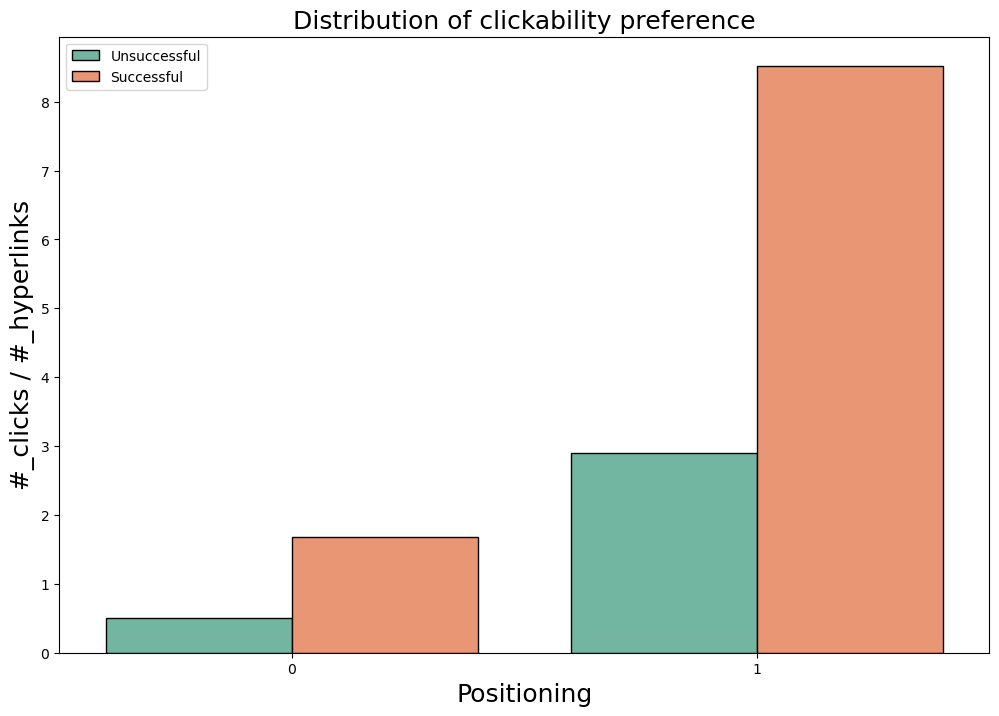

In [79]:
vis_img=pd.concat([links_freq_img_grouped_df_f, links_freq_img_grouped_df_u], axis=0)

fig, ax = plt.subplots(figsize=(12,8), sharey=True)

sns.barplot(y='#_clicks / #_links_img', x=vis_img.index, data=vis_img, palette=sns.color_palette("Set2"), hue='is_successful', edgecolor='k')

ax.set_title('Distribution of clickability preference', fontsize=18)
ax.set_xlabel('Positioning', fontsize=18)
ax.set_ylabel('#_clicks / #_hyperlinks', fontsize=18)
ax.legend_.set_title('')
labels = ['Unsuccessful', 'Successful']
for t, l in zip(ax.legend_.texts, labels):
    t.set_text(l)
plt.savefig('Distribution_clickability_preference_img.png', bbox_inches='tight')

In [80]:
vis_img.to_csv('vis_img.csv')

There is an evident players' clicability preference for hyperlinks showing up in images, both among successful and unsuccessful players. <br>
Moreover, succesfull players click on average more than unsuccessful ones.  

Assumptions: 
1. when a hyperlink shows up in both the article text and in an image caption, it is not possible to extract from the data in our possess what the player's click choice perfomed is. Therefore we assumed that hyperlinks showing up in images' captions don't appear in the text, as the following statement justifies. The normalization, therefore took into account a total number of links in texts equal to  (total number of hyperlinks detected) - (total number of hyperlinks showing up in images' captions). 

In [ ]:
twice=0
for idx in range(len(link_positioning_dfs)):
    if links_in_images[idx] is None:
        continue
    else:
        if set(link_positioning_dfs[idx]['link']).intersection(set(links_in_images[idx]['link'])):
            twice+=1
print('{0} hyperlinks show up both in the text and in an image caption of an article, out of {1} articles.'.format(twice, len(link_positioning_dfs)))

## Regression analysis

In [ ]:
path_lenghts_f=[len(path) for path in clicked_links_filtered_f]
path_lenghts_u=[len(path) for path in clicked_links_filtered_u]

In [ ]:
def find_features(paths_list):
    features=[]
    for path in paths_list:
        features.append([most_freq_positioning_df.loc[link].values.item() 
                         if link in most_freq_positioning_df.index else np.random.choice(['top', 'center-top','center','center-bottom', 'bottom'])
                         for link in path])
    return features

In [ ]:
## to discuss: 3% of links do not show up in most_freq_positioning_df

In [ ]:
features_f=find_features(clicked_links_filtered_f)
features_u=find_features(clicked_links_filtered_u)

In [ ]:
def find_features_frequency(features):
    t=[]
    ct=[]
    c=[]
    cb=[]
    b=[]    
    for path in features:
        t.append(path.count('top'))
        ct.append(path.count('center-top'))
        c.append(path.count('center'))
        cb.append(path.count('center-bottom'))
        b.append(path.count('bottom'))
    return pd.DataFrame({'top': t, 'center_top': ct, 'center': c, 'center_bottom': cb, 'bottom': b})

features_frequency_f=find_features_frequency(features_f)
features_frequency_u=find_features_frequency(features_u)

In [ ]:
def find_features_category(features):
    t=[]
    ct=[]
    c=[]
    cb=[]
    b=[]    
    for path in features:
        t.append(1 if 'top' in path else 0)
        ct.append(1 if 'center-top' in path else 0)
        c.append(1 if 'center' in path else 0)
        cb.append(1 if 'center-bottom' in path else 0)
        b.append(1 if 'bottom' in path else 0)
    return pd.DataFrame({'top': t, 'center_top': ct, 'center': c, 'center_bottom': cb, 'bottom': b})

features_categorical_f=find_features_category(features_f)
features_categorical_u=find_features_category(features_u)

In [ ]:
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [ ]:
reg_df_f=pd.concat([pd.Series(path_lenghts_f, name='pathlength'), features_frequency_f], axis=1)
reg_df_u=pd.concat([pd.Series(path_lenghts_u, name='pathlength'), features_frequency_u], axis=1)

In [ ]:
#normalize features (e.g. #_top_links in path/len(path)) 

def norm_features(df):
    df_new=pd.DataFrame()
    for c in df.columns[1:]:
        df_new[c]=df[c]/df['pathlength']
    return df_new

#standardize features 

def standardize_features(df):
    df_std=pd.DataFrame()
    for c in df.columns:
        df_std[c]=(df[c]-df[c].mean())/df[c].std()
    return df_std

In [ ]:
reg_df_norm_f=norm_features(reg_df_f).reset_index(drop=True)  
reg_df_norm_u=norm_features(reg_df_u).reset_index(drop=True)  

reg_df_norm_std_f=standardize_features(reg_df_norm_f)
reg_df_norm_std_u=standardize_features(reg_df_norm_u)

reg_df_norm_std_f['success']=1
reg_df_norm_std_u['success']=0

In [ ]:
reg_df_norm_std_u=pd.concat([reg_df_norm_std_f, reg_df_norm_std_u], axis=0)

mod= smf.logit(formula='success ~ top + center_top + center + center_bottom + bottom', data=reg_df_norm_std_u)
res=mod.fit()
print(res.summary())

unitary p-values, all coefficients not significant

In [ ]:
reg_C_df_f=pd.concat([pd.Series(path_lenghts_f, name='pathlength'), features_categorical_f], axis=1)
reg_C_df_u=pd.concat([pd.Series(path_lenghts_u, name='pathlength'), features_categorical_u], axis=1)

reg_C_df_f['success']=1
reg_C_df_u['success']=0

reg_C_df=pd.concat([reg_C_df_f, reg_C_df_u], axis=0)

mod_C_f = smf.logit(formula='success ~ C(top) + C(center_top) + C(center) + C(center_bottom) + C(bottom)', data=reg_C_df)
res_C_f=mod_C_f.fit()
print(res_C_f.summary())

# Matched analysis

## Hyperlinks positioning clickability

The methodology chosen for the data processing step is to perform a matched analysis (allowing to obtain actually comparable data) aimed at testing if specific human game strategies lead to success in the Wikispeedia game. 
A logistic regression is conducted with the goal of estimating the parameters of the logistic model with the dependent binary variable being the success (or NOT success) and the independent variables being sequentially extracted the following set of features (different human behaviors/choices when playing the Wikispeedia game):
1. Positioning of the clicked hyperlinks;
2. Clicking hyperlinks in images’ captions. <br>

Several confounders may affect the outcome of the regression analysis i.e. of the potentially found correlation between the aforementioned features and success. To mention a few, the “difficulty” of the randomly assigned task (source and target articles) to players, affects their successfulness together with the strategy adopted to address it. This “difficulty” could be naively measured by shortest path distance between the source and target article in the Wikispeedia hyperlinks graph (calculated with the Floyd-Warshall algorithm). Additionally the actual sequence of clicked hyperlinks (qualitative feature, w.r.t. semantics) and their numerosity along a path (quantitative feature) again reasonably affects players successfulness and their choice for a strategy.  
In order to remove the aforementioned confounders, the dataset is filtered accordingly with the assumptions made. 

In [ ]:
shortest_path_matrix = []

with open(folder+'shortest-path-distance-matrix.txt', 'r') as f:
    # the first 17 lines (indexed from 0) is the file description 
    for line in f.readlines()[17:]:
        shortest_path_matrix.append(line)

In [ ]:
def get_shortest_path(paths_df: pd.DataFrame, successful: bool)-> pd.DataFrame:
    """
    this function takes a DataFrame and returns a DataFrame with the following columns:
       1. human path length
       2. source article
       3. target article
       4. shortest path length
       
    input:
       df: the DataFrame containing all the human navigation paths
       successful or unsuccessful: a boolean indicating whether the paths were successful or not
    """
    #get filtered list of paths and the indeces of the removed  
    paths_list, removed_idxs=get_clicked_links(paths_df) 
    
    human_path_lengths, source_articles, target_articles, shortest_path_lengths = [], [], [], []
    
    articles_list=list(articles.article) #list of articles 
    
    
    def get_source_target(paths_list, removed_idxs, successful):
        """this helper function takes the list of paths and a boolean indicating whether the paths were successfull or not
        and returns the source and target articles for each path"""
        target_articles, shortest_path_lengths = [], []
        
        for human_path in paths_list:

            human_path_lengths.append(len(human_path)-1)

            source=human_path[0]
            source_articles.append(source)

            if successful:
                target=human_path[-1]
                target_articles.append(target)
        
        #target articles for unsuccessful paths need to be extracted from the column 'target' of the df
        if not successful:
            target_articles=paths_df.drop(removed_idxs)['target'].apply(filter_link).reset_index(drop=True)
            
        return human_path_lengths, source_articles, target_articles
    
    human_path_lengths, source_articles, target_articles = get_source_target(paths_list, removed_idxs, successful)
    
    for source, target in zip(source_articles, target_articles):
        
        source_index = articles_list.index(source)
        # there are target articles that were not provided in the plain text files
        try:
            target_index = articles_list.index(target)
        except Exception:
            shortest_path_lengths.append("N/A")
            continue

        # query the shortest path matrix to get the correct vector (corresponding to the source article)
        shortest_path_vector = shortest_path_matrix[source_index]
        # now find the target article indexed integer in the vector
        shortest = shortest_path_vector[target_index]
        # it's not always possible to get to the target article. Impossible navigation is denoted by "_"
        if shortest == "_":
            shortest_path_lengths.append("Impossible")
        else:
            shortest_path_lengths.append(int(shortest))
        
    return pd.DataFrame({'source_article': source_articles, 'target_article': target_articles, 'human_path_length': human_path_lengths, 'shortest_path_length': shortest_path_lengths})

successful_df=get_shortest_path(paths_finished, True)
unsuccessful_df=get_shortest_path(paths_unfinished, False)


In [ ]:
successful_df.head()

In [ ]:
#add the label for each human path 
successful_df['is_successful']=1
unsuccessful_df['is_successful']=0

Known the "label" of each human path, i.e. player's success (`is_successful`) (binary variable equal to 0 for unsuccessful players or 1 for unsuccessful players), its length (`human_path_length`) and the source (`source_article`), target (`target_article`) articles and shortest path distance on the Wikispeedia graph (`shortest_path_length`) of the assigned game, the features of each human path are extrapolated as follows:
1. to each hyperlink clicked in the human path it is assigned its most frequent positioning*;
2. for each path the distribution of the 5 categorical positioning (`top`, `center-top`, `center`, `center-bottom`,`bottom`) of hyperlinks is calculated (their relative frequency: numerical predictor).
3. the values of the variables are standardized**. 

\*its most frequent positioning is determined on the basis of its occurencies in the set of articles making up the Wikispeedia html files database. <br>
\*\* they are not normalized on human path length, as the matching of the players will be done also on human path length.

In [ ]:
def find_features(paths_list):
    '''this function determines the categorical positioning feature of each hyperlink in the human path'''
    features=[]
    for human_path in paths_list:
        features.append([most_freq_positioning_df.loc[link].values.item() 
                         if link in most_freq_positioning_df.index \
                         else np.random.choice(['top', 'center-top','center','center-bottom', 'bottom'])
                         for link in human_path]) #certain hyperlinks were not classified 
    return features

successful_features=find_features(clicked_links_filtered_f)
unsuccessful_features=find_features(clicked_links_filtered_u)

In [ ]:
def find_features_frequency(features):
    '''this function counts the frequency of the categorical positioning features of the hyperlinks in each human path'''
    t, ct, c, cb, b=[], [], [], [], []

    for path in features:
        t.append(path.count('top'))
        ct.append(path.count('center-top'))
        c.append(path.count('center'))
        cb.append(path.count('center-bottom'))
        b.append(path.count('bottom'))
    return pd.DataFrame({'top': t, 'center_top': ct, 'center': c, 'center_bottom': cb, 'bottom': b})

successful_features_freq=find_features_frequency(successful_features)
unsuccessful_features_freq=find_features_frequency(unsuccessful_features)


In [ ]:
#standardize features 

def standardize_features(df):
    df_std=pd.DataFrame()
    for c in df.columns:
        df_std[c]=(df[c]-df[c].mean())/df[c].std()
    return df_std

successful_features_std=standardize_features(successful_features_freq)
unsuccessful_features_std=standardize_features(unsuccessful_features_freq)

In [ ]:
successful_features_std.head()

In [ ]:
#complete dataframe with label and features
successful_positioning_df=pd.concat([successful_df, successful_features_std], axis=1)
unsuccessful_positioning_df=pd.concat([unsuccessful_df, unsuccessful_features_std], axis=1)

In [ ]:
successful_positioning_df.head()

In order to filter the dataframe for the matched analysis, aimed at removing the two highlighted potential confounders for the supposed causal relationship between strategy and success (i.e. difficulty of the game and number of choices performed by the player), a distribution of human path lengths and shortest path distances is plotted with the goal of evaluating the appropriate values of lengths to filter on. This step is essential in order to be able to run algorithms with such large datasets and it is justified as for certain lengths not enough data are provided, therefore any result inferred will be not statistically significant and robust. 

In [ ]:
#distribution of shortest path distance for successful players
successful_positioning_df['shortest_path_length'].value_counts()

In [ ]:
#distribution of shortest path distance for successful players
unsuccessful_positioning_df['shortest_path_length'].value_counts()

In [ ]:
#distribution of human path length for successful players
successful_positioning_df['human_path_length'].value_counts()

In [ ]:
#distribution of human path length for unsuccessful players
unsuccessful_positioning_df['human_path_length'].value_counts()

Human paths with length equal to 1 or 2 are filtered, even if they are the most frequent, as they are respectively associated with no choice performed (i.e. the player did not actually get away from the source article) and no  information on sequential behavior that can be extrapolated, as the player performed 1 choice.

The most numerous shortest path distance for both successful and unsuccessful players is 3. Since enough data (> 30000 inputs) is available filtering on this shortest path distance, it is employed. <br>
The tree most frequent human path lengths for both successful and unsuccessful players are [3,4,5].

In [ ]:
#filter on shortest path length
successful_positioning_rel_df=successful_positioning_df.loc[successful_positioning_df['shortest_path_length'].isin([3])].reset_index(drop=True)
unsuccessful_positioning_rel_df=unsuccessful_positioning_df.loc[unsuccessful_positioning_df['shortest_path_length'].isin([3])].reset_index(drop=True)

In [ ]:
#filter on human path length
successful_positioning_rel_df=successful_positioning_rel_df.loc[successful_positioning_rel_df['human_path_length'].isin([3,4,5])].reset_index(drop=True)
unsuccessful_positioning_rel_df=unsuccessful_positioning_rel_df.loc[unsuccessful_positioning_rel_df['human_path_length'].isin([3,4,5])].reset_index(drop=True)


In [ ]:
successful_positioning_rel_df.head()

The matching is carried out with the following properties:
- treated subject: user performing a specific strategy;
- controlled subject: user NOT performing a specific strategy
  1. clicking more than the average on top-positioned hyperlinks in articles' texts;
  2. clicking more than the average on center-bottom-positioned hyperlinks in the articles' texts;
- match on shortest path distance*;
- match on human path distance.

\*this constraint is already met, as the dataset is filtered on a unique shortest path distance. 

In [ ]:
import networkx as nx
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [ ]:
#dataframe input of the matching algorithm
unbalanced_positioning_df=pd.concat([successful_positioning_rel_df, unsuccessful_positioning_rel_df], axis=0).reset_index(drop=True)

In [ ]:
unbalanced_positioning_df

In [ ]:
#matching for top-positioned hyperlinks clicking behavior

# Separate the treatment and control groups
treatment_df = unbalanced_positioning_df[unbalanced_positioning_df['top']>= 0]
control_df = unbalanced_positioning_df[unbalanced_positioning_df['top'] < 0]

# Create an empty undirected graph
G = nx.Graph()

# Loop through all the pairs of instances
for control_id, control_row in control_df.iterrows():
    for treatment_id, treatment_row in treatment_df.iterrows():

        if control_row['human_path_length'] == treatment_row['human_path_length']: #match by shortest path length
            #Add an edge between the two instances 
            G.add_edge(control_id, treatment_id)

# Generate and return the maximum weight matching on the generated graph
matching = nx.max_weight_matching(G)
matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
balanced_pos_df = unbalanced_pos_df.iloc[matched]


balanced_pos_df.to_csv('top_balanced_df.csv')

In [ ]:
balanced_pos_df['success'].value_counts()

In [ ]:
for treatment in ['top', 'center-bottom']:

    treatment_df = unbalanced_positioning_df[unbalanced_positioning_df[treatment] >= 0]
    control_df = unbalanced_positioning_df[unbalanced_positioning_df[treatment] < 0]

    G = nx.Graph()

    for control_id, control_row in control_df.iterrows():
        for treatment_id, treatment_row in treatment_df.iterrows():
            # Adds an edge only for the same human path length
            if (control_row['human_path_length'] == treatment_row['human_path_length']):
                G.add_edge(control_id, treatment_id)

    matching = nx.max_weight_matching(G)
    matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
    balanced_df = final_df.iloc[matched]

    # save balanced_df
    balanced_df.to_csv(f'{treatment}.csv')


In [ ]:
mod_top = smf.logit(formula='success ~ center_bottom', data=balanced_pos_df)
res_top = mod_top.fit()
print(res_top.summary())

## Hyperlinks in images' captions clickability

The dataframe containing the "label" of each human path (`is_successful`), its length (`human_path_length`) and the source (`source_article`), target (`target_article`) articles and shortest path distance on the Wikispeedia graph (`shortest_path_length`) of the assigned game is already available. The feature holding the information on hyperlinks in image captions clickability is extrapolated as follows:
1. for each human path the numerosity of hyperlinks showing up in images captions is counted (numerical predictor). 
2. the value is standardized*.

\* not normalized on human path length, as the matching of the players will be done also on human path length.

In [ ]:
#list of unique hyperlinks showing up in images'captions
links_in_img=links_in_images_df['link'].unique() 

#count number of hyperlinks in images' captions in each path
successful_img_freq=[np.isin(path, links_in_img).sum() if np.isin(path, links_in_img).sum() else 0 for path in clicked_links_filtered_f]
unsuccessful_img_freq=[np.isin(path, links_in_img).sum() if np.isin(path, links_in_img).sum() else 0 for path in clicked_links_filtered_u]

In [ ]:
#complete dataframe with label and features
successful_img_df=pd.concat([successful_df, pd.Series(successful_img_freq, name='img_freq')], axis=1)
unsuccessful_img_df=pd.concat([unsuccessful_df, pd.Series(unsuccessful_img_freq, name='img_freq')], axis=1)

In [ ]:
#standardize features
successful_img_df['img_freq']=(successful_img_df['img_freq']-successful_img_df['img_freq'].mean())/successful_img_df['img_freq'].std()
unsuccessful_img_df['img_freq']=(unsuccessful_img_df['img_freq']-unsuccessful_img_df['img_freq'].mean())/unsuccessful_img_df['img_freq'].std()


In [ ]:
#filter on shortest path length
successful_img_rel_df=successful_img_df.loc[successful_img_df['shortest_path_length'].isin([3])]
unsuccessful_img_rel_df=unsuccessful_img_df.loc[unsuccessful_img_df['shortest_path_length'].isin([3])]
#filter on human path length
successful_img_rel_df=successful_img_rel_df.loc[successful_img_rel_df['human_path_length'].isin([3,4,5])].reset_index(drop=True)
unsuccessful_img_rel_df=unsuccessful_img_rel_df.loc[unsuccessful_img_rel_df['human_path_length'].isin([3,4,5])].reset_index(drop=True)


In [ ]:
unbalanced_img_df=pd.concat([successful_img_rel_df, unsuccessful_img_rel_df], axis=0)

In [ ]:
unbalanced_img_df.head()

The matching is carried out as before with:
- treated subject: user clicking more than the average on hyperlinks in images' caption;
- controlled subject: user NOT performing this strategy

In [ ]:
# Separate the treatment and control groups
treatment_df = unbalanced_img_df[unbalanced_img_df['img_freq']>=0]
control_df = unbalanced_img_df[unbalanced_img_df['img_freq'] < 0]

# Create an empty undirected graph
G = nx.Graph()

# Loop through all the pairs of instances
for control_id, control_row in control_df.iterrows():
    for treatment_id, treatment_row in treatment_df.iterrows():

        if control_row['human_path_length'] == treatment_row['human_path_length']: #match by shortest path lenght
            #Add an edge between the two instances weighted by the similarity between them
            G.add_edge(control_id, treatment_id)

# Generate and return the maximum weight matching on the generated graph
matching = nx.max_weight_matching(G)

In [ ]:
#get balanced df
matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
balanced_img_df = unbalanced_img_df.iloc[matched]
balanced_img_df['success'].value_counts()
balanced_img_df.to_csv('img_df.csv')

In [ ]:
#dataframe input of the matching algorithm
balanced_img_df=read_csv(folder+'img_df.csv', sep='\t')

In [ ]:
mod_img = smf.logit(formula='success ~ img_freq', data=balanced_img_df)
res_img = mod_img.fit()
print(res_img.summary())

In [ ]:
#count how many data we would have if matching on source and target article
successful_df.groupby(by=['source_article', 'target_article']).count()

In [ ]:
len(successful_df)